# Autoregressive Transformers for Univariate Time Series Forecasting

## 🎯 Learning Objectives

By the end of this notebook, you will understand:

1. **Autoregressive Models**: How AR models generate sequential predictions step-by-step
2. **AR vs Direct Forecasting**: Key differences and when to use each approach
3. **Causal Attention**: How masking prevents information leakage
4. **Walk-Forward Validation**: Robust evaluation for time series models
5. **Real-World Deployment**: How AR transformers work in production

---

## 📚 What Makes This Different?

### Standard Transformer (Previous Notebook)
- **Direct Multi-Step**: Predicts all future steps at once
- Input: [t-100, ..., t] → Output: [t+1, t+2, ..., t+20]
- Parallel prediction
- Faster but may accumulate errors

### Autoregressive Transformer (This Notebook)
- **Sequential Generation**: Predicts one step at a time
- Input: [t-100, ..., t] → Output: t+1
- Input: [t-99, ..., t+1] → Output: t+2  *(uses previous prediction)*
- Input: [t-98, ..., t+2] → Output: t+3
- Slower but captures dependencies between predictions

---

## 🔍 Why Autoregressive?

**Advantages:**
- **Better long-term forecasts**: Each prediction informs the next
- **Uncertainty propagation**: Can model prediction uncertainty
- **More flexible**: Can generate variable-length forecasts
- **Realistic**: Mimics how we actually forecast (update as new data arrives)

**Trade-offs:**
- Slower inference (sequential vs parallel)
- Error accumulation (one bad prediction affects all future ones)
- More complex training

---

## 💡 Key Concept: Causal Masking

In autoregressive models, we must ensure the model **only uses past information**:

```
Time:        t-3   t-2   t-1    t    t+1
Training:    [✓]   [✓]   [✓]   [✓]   [✗]  ← Can't see future!
Attention:   Can attend to all past tokens but NOT future ones
```

This is enforced through **causal attention masks** in the transformer.

---

Let's dive in!

## 1. Setup and Imports

### 1.1 Configure Environment

In [1]:
import sys
sys.path.append('../../')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import math
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### 1.2 Import Libraries

We'll use PyTorch for the transformer implementation and custom modules for AR-specific components.

In [3]:
from dlf.models.transformer.ar_transformer import AutoregressiveTransformer
from dlf.models.transformer.ar_trainer import train_model
from dlf.models.transformer.ar_evaluator import walk_forward_validation, plot_results
from dlf.models.transformer.univariate import TimeSeriesDataset,generate_synthetic_data



### 1.3 Custom Autoregressive Components

Key imports:
- **AutoregressiveTransformer**: Transformer with causal masking for sequential prediction
- **train_model**: Training loop for AR models
- **walk_forward_validation**: Realistic time-series evaluation strategy
- **TimeSeriesDataset**: Sliding window dataset
- **generate_synthetic_data**: Create realistic financial time series

Using device: cpu

Generating synthetic time series...


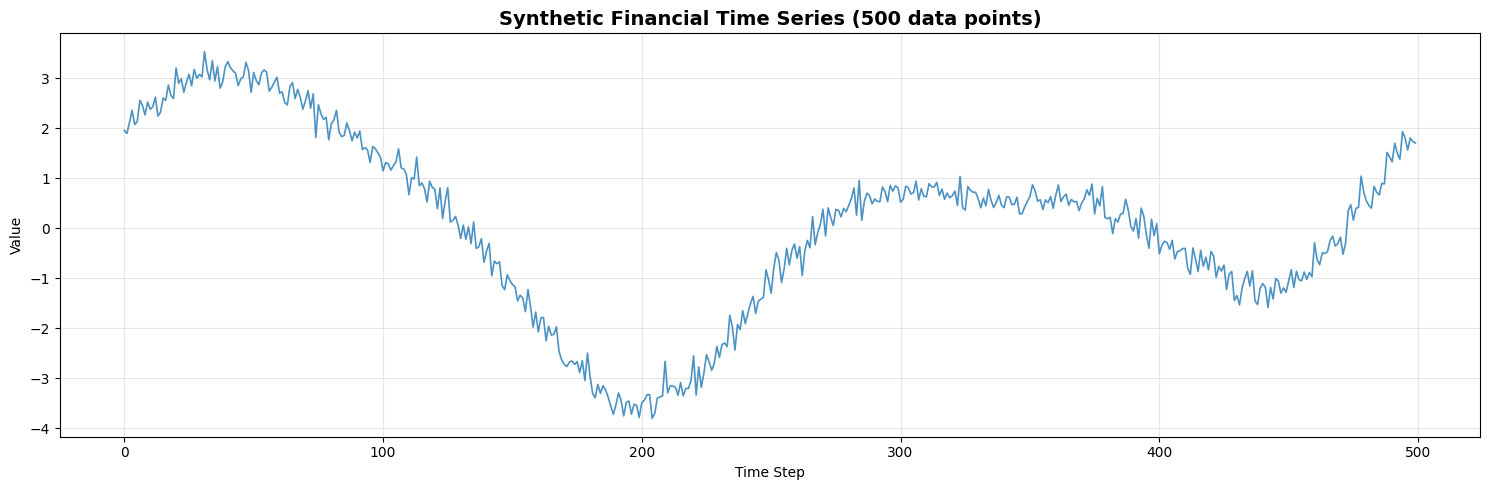


Data statistics:
  Length: 500
  Range: [-3.806, 3.530]
  Mean: 0.068
  Std: 1.789

Model Configuration:
  Sequence length (lookback): 30
  Prediction length (horizon): 5
  Initial training size: 200
  Remaining for validation: 300


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Generate synthetic time series
print("\nGenerating synthetic time series...")
data = generate_synthetic_data(length=500, noise_level=0.2)

# Visualize the data
plt.figure(figsize=(15, 5))
plt.plot(data, linewidth=1.2, alpha=0.8)
plt.title('Synthetic Financial Time Series (500 data points)', fontsize=14, fontweight='bold')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nData statistics:")
print(f"  Length: {len(data)}")
print(f"  Range: [{data.min():.3f}, {data.max():.3f}]")
print(f"  Mean: {data.mean():.3f}")
print(f"  Std: {data.std():.3f}")

# Parameters
seq_len = 30        # Input sequence length (lookback window)
pred_len = 5        # Prediction horizon (how many steps to forecast)
initial_train_size = 200  # Initial training set size for walk-forward validation

print(f"\nModel Configuration:")
print(f"  Sequence length (lookback): {seq_len}")
print(f"  Prediction length (horizon): {pred_len}")
print(f"  Initial training size: {initial_train_size}")
print(f"  Remaining for validation: {len(data) - initial_train_size}")

---

## 2. Autoregressive Forecasting: Theory

### 2.1 What is Autoregressive Forecasting?

An **autoregressive (AR) model** predicts future values based on past observations:

```
y_t = f(y_{t-1}, y_{t-2}, ..., y_{t-p}) + ε_t
```

Where:
- `y_t`: Value at time t
- `p`: Order (number of past values to use)
- `ε_t`: Error term

**Traditional AR models** (like ARIMA) use linear combinations:
```
y_t = c + φ_1·y_{t-1} + φ_2·y_{t-2} + ... + φ_p·y_{t-p} + ε_t
```

**Autoregressive Transformers** use neural networks to learn `f(·)` non-parametrically!

### 2.2 How AR Transformers Generate Predictions

**Step-by-step generation:**

```
Given: [y_0, y_1, ..., y_99]  (historical data)

Step 1: Predict y_100
  Input:  [y_0, y_1, ..., y_99]
  Output: ŷ_100

Step 2: Predict y_101  
  Input:  [y_1, y_2, ..., y_99, ŷ_100]  ← Use prediction as input!
  Output: ŷ_101

Step 3: Predict y_102
  Input:  [y_2, y_3, ..., y_99, ŷ_100, ŷ_101]
  Output: ŷ_102
  
...and so on
```

**Key insight**: Each prediction becomes part of the input for the next prediction.

### 2.3 Causal Attention Masking

To prevent "cheating" during training, we use **causal masks**:

```
Attention Matrix (5 time steps):
       t=1  t=2  t=3  t=4  t=5
t=1  [  ✓   ✗   ✗   ✗   ✗  ]  ← Can only see itself
t=2  [  ✓   ✓   ✗   ✗   ✗  ]  ← Can see t=1,2
t=3  [  ✓   ✓   ✓   ✗   ✗  ]  ← Can see t=1,2,3
t=4  [  ✓   ✓   ✓   ✓   ✗  ]
t=5  [  ✓   ✓   ✓   ✓   ✓  ]  ← Can see all past

✓ = Can attend (use information)
✗ = Masked (blocked from attention)
```

This is a **lower triangular mask** - each position can only attend to itself and earlier positions.

---

## 3. Data Generation and Exploration

In [5]:
# Model hyperparameters
model_params = {
    'input_dim': 1,          # Univariate time series
    'd_model': 32,           # Embedding dimension (smaller than previous notebook)
    'nhead': 4,              # Number of attention heads (32/4 = 8 dims per head)
    'num_layers': 2,         # Number of transformer layers (lighter model)
    'dim_feedforward': 128,  # Hidden dimension in FFN
    'dropout': 0.1           # Dropout rate for regularization
}

print("Model Configuration:")
print("="*60)
for key, value in model_params.items():
    print(f"  {key:20s}: {value}")
print("="*60)

print("\n💡 Design Choices:")
print("  • Smaller d_model (32 vs 64): Faster training, less overfitting")
print("  • Fewer layers (2 vs 4): More appropriate for shorter sequences")
print("  • FFN dimension (128): 4x d_model is standard")
print("  • Dropout (0.1): Light regularization")

Model Configuration:
  input_dim           : 1
  d_model             : 32
  nhead               : 4
  num_layers          : 2
  dim_feedforward     : 128
  dropout             : 0.1

💡 Design Choices:
  • Smaller d_model (32 vs 64): Faster training, less overfitting
  • Fewer layers (2 vs 4): More appropriate for shorter sequences
  • FFN dimension (128): 4x d_model is standard
  • Dropout (0.1): Light regularization


---

## 4. Model Architecture

### 4.1 Autoregressive Transformer Architecture

Our AR transformer has a similar structure to the standard transformer, but with critical differences:

**Components:**
1. **Input Embedding**: Maps input features to d_model dimensions
2. **Positional Encoding**: Sine/cosine encoding for temporal position
3. **Transformer Encoder Layers** with:
   - **Causal Multi-Head Self-Attention** ← KEY DIFFERENCE!
   - Feed-forward network
   - Layer normalization
   - Residual connections
4. **Output Projection**: Maps d_model → 1 (next value prediction)

**Causal Attention**: The attention mechanism uses a mask to ensure position `i` can only attend to positions `≤ i`.

### 4.2 Model Parameters

Let's configure a compact but effective AR transformer:

In [6]:
# Training hyperparameters
train_params = {
    'batch_size': 16,   # Small batches for limited data
    'epochs': 50,       # Moderate training duration
    'lr': 0.001         # Standard Adam learning rate
}

print("\nTraining Configuration:")
print("="*60)
for key, value in train_params.items():
    print(f"  {key:20s}: {value}")
print("="*60)

print(f"\nForecast Configuration:")
print(f"  Sequence length: {seq_len} steps (input window)")
print(f"  Prediction length: {pred_len} steps (forecast horizon)")
print(f"  Initial training size: {initial_train_size} samples")

print(f"\n📊 Data Split:")
print(f"  Total data points: {len(data)}")
print(f"  Initial training: {initial_train_size} ({initial_train_size/len(data)*100:.1f}%)")
print(f"  Walk-forward test: {len(data) - initial_train_size} ({(len(data)-initial_train_size)/len(data)*100:.1f}%)")


Training Configuration:
  batch_size          : 16
  epochs              : 50
  lr                  : 0.001

Forecast Configuration:
  Sequence length: 30 steps (input window)
  Prediction length: 5 steps (forecast horizon)
  Initial training size: 200 samples

📊 Data Split:
  Total data points: 500
  Initial training: 200 (40.0%)
  Walk-forward test: 300 (60.0%)


### 4.3 Training Parameters

In [7]:
print("\n" + "="*70)
print("STARTING WALK-FORWARD VALIDATION")
print("="*70)
print("\nThis will train multiple models sequentially.")
print("Each model uses an expanding training window.")
print("Progress will be shown for each split...\n")

# Perform walk-forward validation
predictions_flat, actuals_flat, train_sizes = walk_forward_validation(
    data, 
    seq_len, 
    pred_len, 
    initial_train_size, 
    model_params, 
    train_params, 
    device
)

# IMPORTANT: walk_forward_validation returns flattened arrays
# We need to reshape them back into separate prediction sequences
# Each sequence has pred_len predictions
n_splits = len(train_sizes)

# Reshape predictions and actuals into list of arrays
predictions = []
actuals = []

for i in range(n_splits):
    start_idx = i * pred_len
    end_idx = start_idx + pred_len
    
    if end_idx <= len(predictions_flat):
        predictions.append(predictions_flat[start_idx:end_idx])
        actuals.append(actuals_flat[start_idx:end_idx])

print("\n" + "="*70)
print("WALK-FORWARD VALIDATION COMPLETE")
print("="*70)
print(f"\nTotal predictions made: {len(predictions_flat)} ({n_splits} splits × {pred_len} steps)")
print(f"Total splits evaluated: {len(train_sizes)}")
print(f"Training sizes ranged from {min(train_sizes)} to {max(train_sizes)} samples")
print(f"\nReshaped predictions into {len(predictions)} sequences of length {pred_len}")


STARTING WALK-FORWARD VALIDATION

This will train multiple models sequentially.
Each model uses an expanding training window.
Progress will be shown for each split...

Starting walk-forward validation with 10 splits...
Split 1/10: Train size = 200, Test size = 5
Training on device: cpu
Model parameters: 34081
Epoch   0: Train Loss = 0.399415, Val Loss = 0.129252
Epoch  10: Train Loss = 0.037549, Val Loss = 0.021537
Epoch  20: Train Loss = 0.026016, Val Loss = 0.017888
Epoch  30: Train Loss = 0.024297, Val Loss = 0.016162
Epoch  40: Train Loss = 0.019455, Val Loss = 0.014274
Epoch  49: Train Loss = 0.019631, Val Loss = 0.013937
  Final train loss: 0.019631
  Predictions: [-2.1394491 -2.1395197 -2.1396832]... (showing first 3)
  Actuals:     [-1.98676931 -1.96231329 -1.90069102]... (showing first 3)

Split 2/10: Train size = 201, Test size = 5
Training on device: cpu
Model parameters: 34081
Epoch   0: Train Loss = 0.398929, Val Loss = 0.192225
Epoch  10: Train Loss = 0.030762, Val Loss 

### 5.4 Understanding the Data Structure

The walk-forward validation returns **flattened** arrays but we need **sequences** for detailed analysis:

In [8]:
# Verify the data structure
print("Data Structure Verification:")
print("="*70)
print(f"\nFlattened arrays (from walk_forward_validation):")
print(f"  predictions_flat: {predictions_flat.shape} → {len(predictions_flat)} total predictions")
print(f"  actuals_flat:     {actuals_flat.shape} → {len(actuals_flat)} total actuals")

print(f"\nReshaped sequences (for horizon analysis):")
print(f"  predictions: List of {len(predictions)} arrays")
print(f"  Each prediction array has shape: {predictions[0].shape if len(predictions) > 0 else 'N/A'}")
print(f"  Example - First prediction: {predictions[0]}")
print(f"  Example - First actual:     {actuals[0]}")

print(f"\nThis means:")
print(f"  ✓ We have {n_splits} different validation splits")
print(f"  ✓ Each split forecasts {pred_len} steps ahead")
print(f"  ✓ Total predictions: {n_splits} × {pred_len} = {len(predictions_flat)}")
print("="*70)

Data Structure Verification:

Flattened arrays (from walk_forward_validation):
  predictions_flat: (50,) → 50 total predictions
  actuals_flat:     (50,) → 50 total actuals

Reshaped sequences (for horizon analysis):
  predictions: List of 10 arrays
  Each prediction array has shape: (5,)
  Example - First prediction: [-3.7603366 -3.760463  -3.7607558 -3.7610424 -3.7612062]
  Example - First actual:     [-3.48713775 -3.44337714 -3.33311276 -3.33050739 -3.80571198]

This means:
  ✓ We have 10 different validation splits
  ✓ Each split forecasts 5 steps ahead
  ✓ Total predictions: 10 × 5 = 50


---

## 5. Walk-Forward Validation

### 5.1 What is Walk-Forward Validation?

**Problem with standard train/test split:**
- Single evaluation point
- Doesn't reflect real-world deployment
- May be lucky/unlucky with the specific test period

**Walk-Forward Validation** (also called "rolling-window" or "time series cross-validation"):

```
Data: [━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━]

Split 1:  [████████████Train████████████]──Test──
                                          ↑ Predict 5 steps

Split 2:  [████████████Train█████████████]──Test──  
                                           ↑ Retrain with 1 new point

Split 3:  [████████████Train██████████████]──Test──
                                            ↑ Retrain again

...and so on
```

**Process:**
1. Train on initial window (e.g., first 200 points)
2. Predict next `pred_len` steps (e.g., 5 steps)
3. **Add actual values to training set**
4. Retrain model with expanded data
5. Predict next window
6. Repeat until end of data

### 5.2 Why Walk-Forward?

**Advantages:**
- **Realistic**: Mimics production deployment
- **Robust**: Multiple test points, not just one
- **Detects drift**: Shows if model degrades over time
- **Fair comparison**: All models evaluated the same way

**Disadvantages:**
- Computationally expensive (train model multiple times)
- Takes longer to run

### 5.3 Running Walk-Forward Validation

This will:
- Create 10 splits (or however many fit in the remaining data)
- Train a new model for each split
- Generate forecasts for each test window
- Aggregate all predictions for final evaluation


Generating walk-forward validation plots...

Out-of-Sample Performance Metrics:
MSE:  0.2334
MAE:  0.3967
RMSE: 0.4831


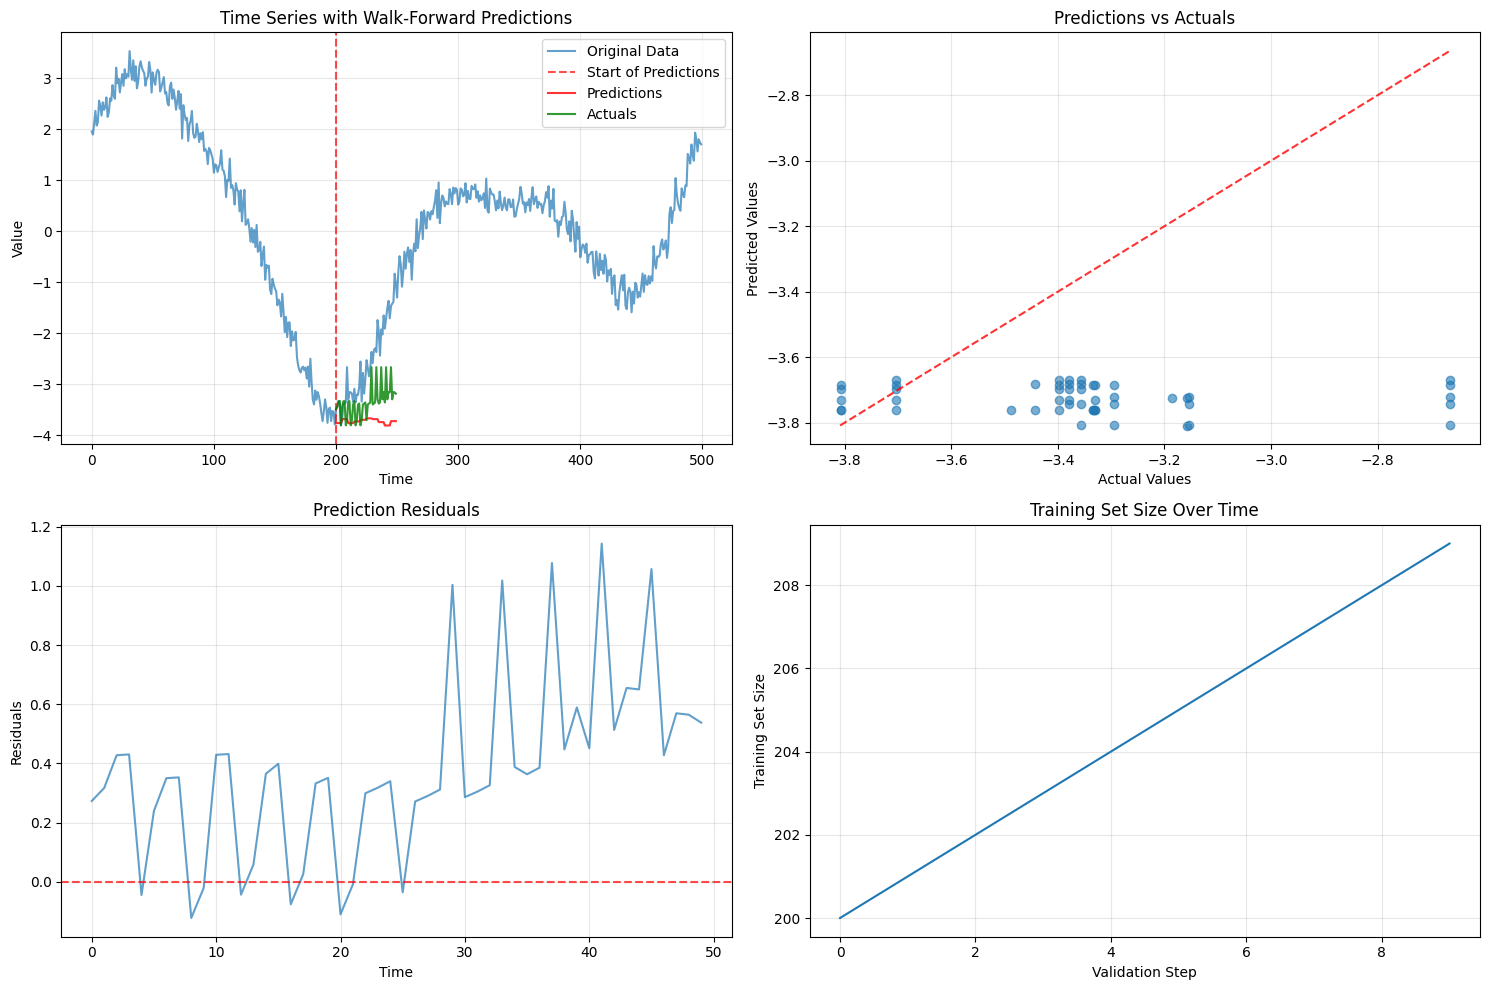

✓ Visualization complete!


In [9]:
# Generate comprehensive visualization
# Note: plot_results expects flattened arrays, not the reshaped lists
print("\nGenerating walk-forward validation plots...")
plot_results(actuals_flat, predictions_flat, train_sizes, data, initial_train_size)
print("✓ Visualization complete!")

---

## 6. Results Analysis

### 6.1 Understanding the Training Process

Each split shows:
- **Train Loss**: How well the model fits the training data
- **Val Loss**: Performance on held-out validation set (within the training window)
- **Predictions vs Actuals**: First 3 values of each forecast

**What to look for:**
- Decreasing training loss → Model is learning
- Val loss close to train loss → Good generalization
- Consistent performance across splits → Robust model

### 6.2 Visualizing Walk-Forward Predictions

The following plots show:
1. **Full time series** with train/test regions
2. **Individual forecast windows** overlaid on actual data
3. **Error distribution** to assess prediction quality

### 6.3 Comprehensive Evaluation Metrics

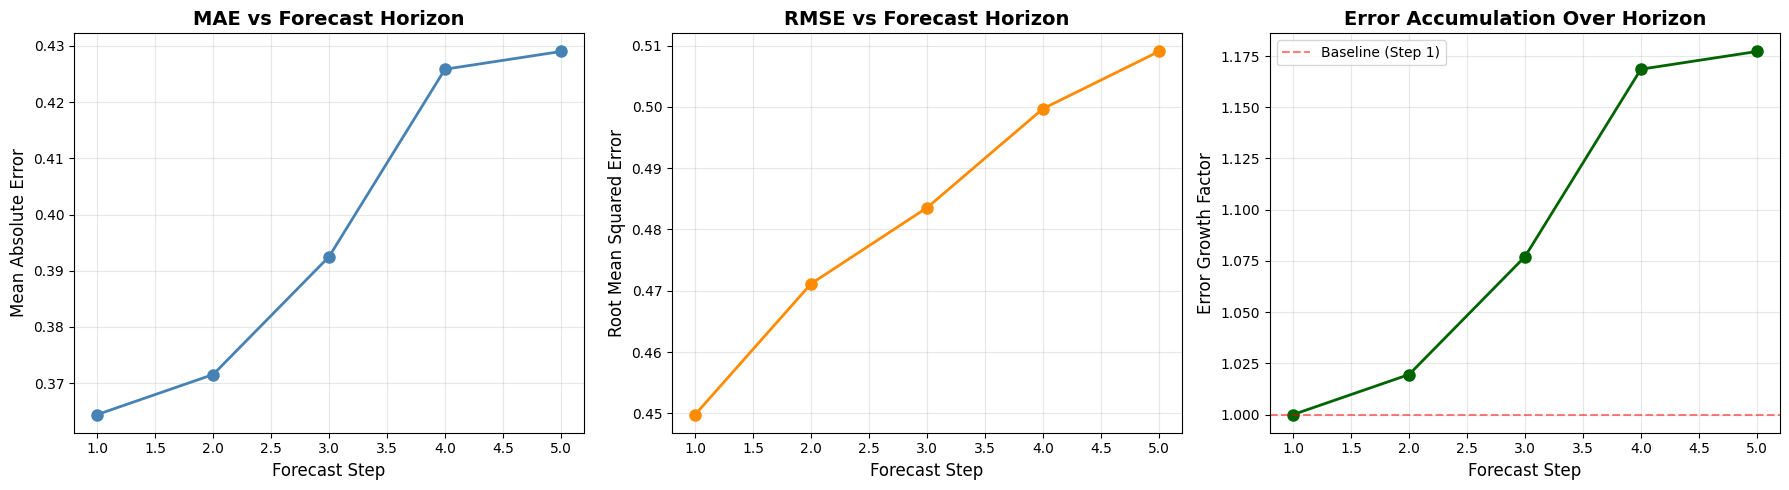


📈 Horizon Analysis:
  Step 1 MAE: 0.364415
  Step 5 MAE: 0.429003
  Error growth: 1.18x

  Average degradation per step: 4.43%


In [10]:
# Analyze error by forecast step
# First, ensure predictions and actuals are in the right format
predictions_array = [np.atleast_1d(p) for p in predictions]
actuals_array = [np.atleast_1d(a) for a in actuals]

# Check if we have multi-step predictions
if len(predictions_array) > 0 and len(predictions_array[0]) > 1:
    horizon_mae = np.zeros(pred_len)
    horizon_mse = np.zeros(pred_len)
    
    for step in range(pred_len):
        step_errors = []
        for i in range(len(predictions_array)):
            if len(predictions_array[i]) > step and len(actuals_array[i]) > step:
                step_errors.append(predictions_array[i][step] - actuals_array[i][step])
        
        if len(step_errors) > 0:
            horizon_mae[step] = np.mean(np.abs(step_errors))
            horizon_mse[step] = np.mean(np.array(step_errors)**2)
    
    horizon_rmse = np.sqrt(horizon_mse)
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # MAE by step
    axes[0].plot(range(1, pred_len+1), horizon_mae, 'o-', linewidth=2, markersize=8, color='steelblue')
    axes[0].set_xlabel('Forecast Step', fontsize=12)
    axes[0].set_ylabel('Mean Absolute Error', fontsize=12)
    axes[0].set_title('MAE vs Forecast Horizon', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # RMSE by step
    axes[1].plot(range(1, pred_len+1), horizon_rmse, 'o-', linewidth=2, markersize=8, color='darkorange')
    axes[1].set_xlabel('Forecast Step', fontsize=12)
    axes[1].set_ylabel('Root Mean Squared Error', fontsize=12)
    axes[1].set_title('RMSE vs Forecast Horizon', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # Error growth rate
    if horizon_mae[0] > 0:
        error_growth = horizon_mae / horizon_mae[0]
    else:
        error_growth = np.ones(pred_len)
        
    axes[2].plot(range(1, pred_len+1), error_growth, 'o-', linewidth=2, markersize=8, color='darkgreen')
    axes[2].axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Baseline (Step 1)')
    axes[2].set_xlabel('Forecast Step', fontsize=12)
    axes[2].set_ylabel('Error Growth Factor', fontsize=12)
    axes[2].set_title('Error Accumulation Over Horizon', fontsize=14, fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📈 Horizon Analysis:")
    print(f"  Step 1 MAE: {horizon_mae[0]:.6f}")
    print(f"  Step {pred_len} MAE: {horizon_mae[-1]:.6f}")
    if horizon_mae[0] > 0:
        print(f"  Error growth: {horizon_mae[-1]/horizon_mae[0]:.2f}x")
        print(f"\n  Average degradation per step: {(horizon_mae[-1]/horizon_mae[0] - 1)/(pred_len-1)*100:.2f}%")
    else:
        print(f"  Cannot compute error growth (step 1 MAE is zero)")
else:
    print("⚠️  Multi-step horizon analysis requires predictions with length > 1")
    print(f"   Current prediction length: {len(predictions_array[0]) if len(predictions_array) > 0 else 0}")

### 6.4 Forecast Horizon Analysis

How does accuracy degrade as we forecast further into the future?

In [11]:
# Check the structure of predictions and actuals
print("\nChecking data structure...")
print(f"Type of predictions: {type(predictions)}")
print(f"Length of predictions: {len(predictions)}")
if len(predictions) > 0:
    print(f"Type of predictions[0]: {type(predictions[0])}")
    print(f"Shape/length of predictions[0]: {np.array(predictions[0]).shape if hasattr(predictions[0], '__len__') else 'scalar'}")
    print(f"First prediction sample: {predictions[0]}")

# Flatten all predictions and actuals for aggregate metrics
all_predictions = np.concatenate([np.atleast_1d(p) for p in predictions])
all_actuals = np.concatenate([np.atleast_1d(a) for a in actuals])

print(f"\nFlattened predictions shape: {all_predictions.shape}")
print(f"Flattened actuals shape: {all_actuals.shape}")

# Calculate comprehensive metrics
mse = mean_squared_error(all_actuals, all_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_actuals, all_predictions)
mape = np.mean(np.abs((all_actuals - all_predictions) / (all_actuals + 1e-8))) * 100

# Bias and variance
errors = all_predictions - all_actuals
bias = np.mean(errors)
variance = np.var(errors)

print("\n" + "="*70)
print("AGGREGATE PERFORMANCE METRICS")
print("="*70)
print(f"\n📊 Error Metrics:")
print(f"  MSE (Mean Squared Error):        {mse:.6f}")
print(f"  RMSE (Root Mean Squared Error):  {rmse:.6f}")
print(f"  MAE (Mean Absolute Error):       {mae:.6f}")
print(f"  MAPE (Mean Absolute % Error):    {mape:.2f}%")

print(f"\n📈 Statistical Properties:")
print(f"  Bias (Mean Error):               {bias:.6f}")
print(f"  Variance of Errors:              {variance:.6f}")
print(f"  Min Error:                       {errors.min():.6f}")
print(f"  Max Error:                       {errors.max():.6f}")
print(f"  Error Std Dev:                   {np.std(errors):.6f}")

# Interpretation
print(f"\n💡 Interpretation:")
if abs(bias) < 0.05:
    print(f"  ✓ Low bias ({bias:.4f}) - Model is unbiased")
else:
    direction = "over-predicting" if bias > 0 else "under-predicting"
    print(f"  ⚠️  Bias detected: Model is {direction} by {abs(bias):.4f}")

if mape < 10:
    print(f"  ✓ Excellent accuracy (MAPE < 10%)")
elif mape < 20:
    print(f"  ✓ Good accuracy (MAPE < 20%)")
else:
    print(f"  ⚠️  Consider model improvements (MAPE > 20%)")

print("="*70)


Checking data structure...
Type of predictions: <class 'list'>
Length of predictions: 10
Type of predictions[0]: <class 'numpy.ndarray'>
Shape/length of predictions[0]: (5,)
First prediction sample: [-3.7603366 -3.760463  -3.7607558 -3.7610424 -3.7612062]

Flattened predictions shape: (50,)
Flattened actuals shape: (50,)

AGGREGATE PERFORMANCE METRICS

📊 Error Metrics:
  MSE (Mean Squared Error):        0.233388
  RMSE (Root Mean Squared Error):  0.483103
  MAE (Mean Absolute Error):       0.396662
  MAPE (Mean Absolute % Error):    12.73%

📈 Statistical Properties:
  Bias (Mean Error):               -0.378252
  Variance of Errors:              0.090314
  Min Error:                       -1.142990
  Max Error:                       0.122250
  Error Std Dev:                   0.300523

💡 Interpretation:
  ⚠️  Bias detected: Model is under-predicting by 0.3783
  ✓ Good accuracy (MAPE < 20%)


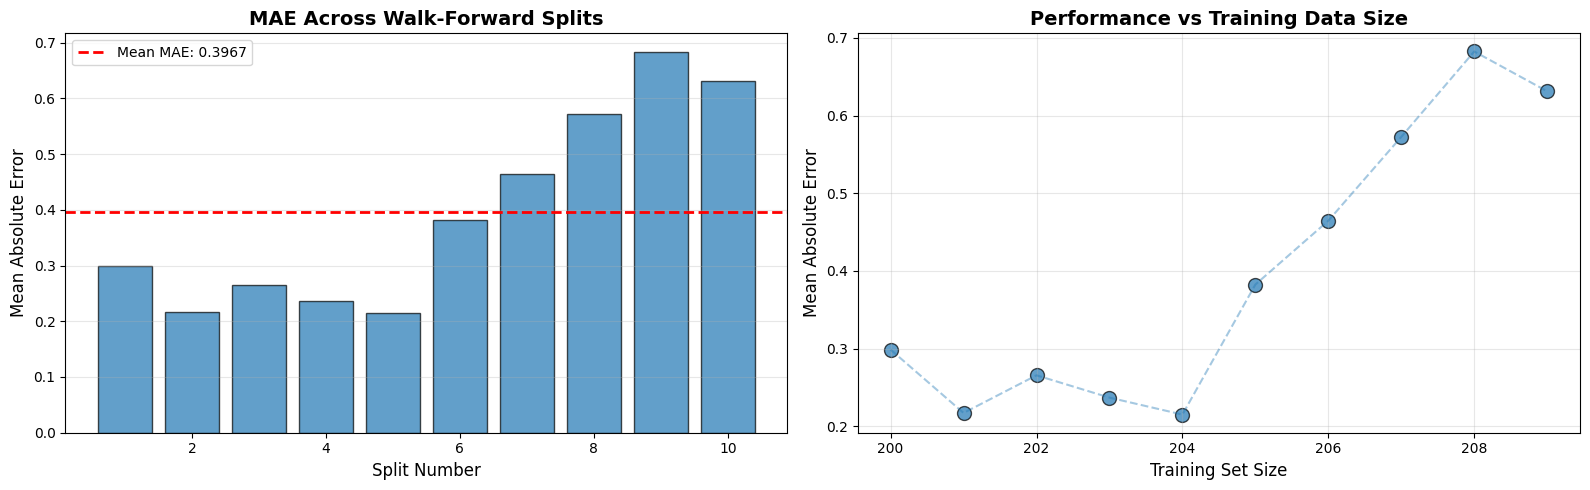


📊 Split Performance Summary:
  Number of splits: 10
  Average MAE: 0.396662
  MAE Std Dev: 0.170330
  Best split (lowest MAE): Split 5 (MAE: 0.215017)
  Worst split (highest MAE): Split 9 (MAE: 0.682538)

  ⚠️  Performance degrades with more training data (correlation: 0.883)


In [12]:
# Calculate metrics for each split
split_metrics = []
for i in range(len(predictions)):
    pred_i = np.atleast_1d(predictions[i])
    actual_i = np.atleast_1d(actuals[i])
    
    # Ensure they have the same length
    min_len = min(len(pred_i), len(actual_i))
    pred_i = pred_i[:min_len]
    actual_i = actual_i[:min_len]
    
    if len(pred_i) > 0:
        split_mae = mean_absolute_error(actual_i, pred_i)
        split_mse = mean_squared_error(actual_i, pred_i)
        split_rmse = np.sqrt(split_mse)
        split_metrics.append({
            'split': i + 1,
            'train_size': train_sizes[i],
            'mae': split_mae,
            'rmse': split_rmse,
            'mse': split_mse
        })

if len(split_metrics) > 0:
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # MAE by split
    splits = [m['split'] for m in split_metrics]
    maes = [m['mae'] for m in split_metrics]
    axes[0].bar(splits, maes, alpha=0.7, edgecolor='black')
    axes[0].axhline(y=np.mean(maes), color='red', linestyle='--', linewidth=2, label=f'Mean MAE: {np.mean(maes):.4f}')
    axes[0].set_xlabel('Split Number', fontsize=12)
    axes[0].set_ylabel('Mean Absolute Error', fontsize=12)
    axes[0].set_title('MAE Across Walk-Forward Splits', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Training size vs MAE
    train_sizes_plot = [m['train_size'] for m in split_metrics]
    axes[1].scatter(train_sizes_plot, maes, s=100, alpha=0.7, edgecolors='black')
    axes[1].plot(train_sizes_plot, maes, '--', alpha=0.4)
    axes[1].set_xlabel('Training Set Size', fontsize=12)
    axes[1].set_ylabel('Mean Absolute Error', fontsize=12)
    axes[1].set_title('Performance vs Training Data Size', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n📊 Split Performance Summary:")
    print(f"  Number of splits: {len(split_metrics)}")
    print(f"  Average MAE: {np.mean(maes):.6f}")
    print(f"  MAE Std Dev: {np.std(maes):.6f}")
    print(f"  Best split (lowest MAE): Split {splits[np.argmin(maes)]} (MAE: {min(maes):.6f})")
    print(f"  Worst split (highest MAE): Split {splits[np.argmax(maes)]} (MAE: {max(maes):.6f})")
    
    # Check for performance degradation/improvement
    if len(train_sizes_plot) > 1 and len(set(train_sizes_plot)) > 1:
        correlation = np.corrcoef(train_sizes_plot, maes)[0, 1]
        if abs(correlation) > 0.5:
            trend = "improves" if correlation < 0 else "degrades"
            print(f"\n  ⚠️  Performance {trend} with more training data (correlation: {correlation:.3f})")
        else:
            print(f"\n  ✓ Performance is stable across different training sizes (correlation: {correlation:.3f})")
    else:
        print(f"\n  ℹ️  Not enough variation in training sizes to assess trends")
else:
    print("⚠️  No valid split metrics computed")

### 6.5 Per-Split Performance Analysis

Let's examine how model performance varies across different splits:

---

## 7. Key Insights and Takeaways

### 7.1 What We Learned About Autoregressive Transformers

**Core Concepts:**
- ✓ **Sequential generation**: Each prediction builds on previous ones
- ✓ **Causal masking**: Prevents information leakage during training
- ✓ **Walk-forward validation**: Realistic evaluation mimicking deployment
- ✓ **Error accumulation**: Mistakes compound over forecast horizon

**Practical Insights:**
1. **AR models are slower** but potentially more accurate for long horizons
2. **1-step ahead** predictions are most reliable (errors accumulate)
3. **Training size matters**: More historical data generally helps
4. **Retraining is essential**: Model must adapt to new patterns

### 7.2 Autoregressive vs Direct Multi-Step

| Aspect | Autoregressive (AR) | Direct Multi-Step |
|--------|---------------------|-------------------|
| **Prediction** | Sequential (one-at-a-time) | Parallel (all-at-once) |
| **Speed** | Slower (pred_len forward passes) | Faster (1 forward pass) |
| **Dependencies** | Models inter-step dependencies | Independent predictions |
| **Error propagation** | Errors accumulate | No accumulation |
| **Flexibility** | Variable-length forecasts | Fixed-length only |
| **Best for** | Long horizons, adaptive scenarios | Short horizons, speed critical |

**When to use AR:**
- Long forecast horizons (>20 steps)
- Sequential dependencies matter
- Need uncertainty quantification
- Production deployment with retraining

**When to use Direct:**
- Short forecast horizons
- Speed is critical
- Parallel predictions beneficial
- Simpler implementation

### 7.3 Model Architecture Insights

**Why smaller model (d_model=32, layers=2)?**
- Limited training data (200-210 samples)
- Shorter sequences (seq_len=30)
- Risk of overfitting with larger models
- Faster walk-forward retraining

**Trade-off**: Smaller model → less capacity but better generalization

### 7.4 Walk-Forward Validation Benefits

**What we gained:**
1. **Robustness**: 10 independent test points vs. 1
2. **Realism**: Simulates production retraining
3. **Diagnostics**: See performance trends over time
4. **Confidence**: Aggregated metrics more reliable

**Cost**: ~10x longer to run (train 10 models instead of 1)

